#  Optimizing Model Prediction

This task, we are to optimize the linear regression model to predict the extent of fire damage to a forest. Our data comes from the Forest Fires dataset from the UCI Machine Learning Repository. This dataset contains information on fires, along with the resulting damage and associated meteorological data. We want to know how these characteristics might be useful in predicting future fire damage.

- X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
- Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
- month - month of the year: 'jan' to 'dec'
- day - day of the week: 'mon' to 'sun'
- FFMC - FFMC index from the FWI system: 18.7 to 96.20
- DMC - DMC index from the FWI system: 1.1 to 291.3
- DC - DC index from the FWI system: 7.9 to 860.6
- ISI - ISI index from the FWI system: 0.0 to 56.10
- temp - temperature in Celsius degrees: 2.2 to 33.30
- RH - relative humidity in %: 15.0 to 100
- wind - wind speed in km/h: 0.40 to 9.40
- rain - outside rain in mm/m2 : 0.0 to 6.4
- area - the burned area of the forest (in ha): 0.00 to 1090.84

In [46]:
# Importing all necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SequentialFeatureSelector

In [24]:
fires = pd.read_csv('fires.csv')

fires.head() # Display the first few roles of the dataset

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


In [25]:
fires.shape # Number of Observation & Features

(517, 14)

In [26]:
fires.columns

Index(['Unnamed: 0', 'X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI',
       'temp', 'RH', 'wind', 'rain', 'area'],
      dtype='object')

In [27]:
fires.isna().sum() # Checking for missing values

Unnamed: 0     0
X              0
Y              0
month          0
day            0
FFMC          48
DMC           21
DC            43
ISI            2
temp          21
RH            30
wind          35
rain          32
area           0
dtype: int64

The following columns 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain' having missing values and will be cleaned by Imputation with the simple or knn imputer object

In [28]:
fires.dtypes

Unnamed: 0      int64
X               int64
Y               int64
month          object
day            object
FFMC          float64
DMC           float64
DC            float64
ISI           float64
temp          float64
RH            float64
wind          float64
rain          float64
area          float64
dtype: object

In [29]:
# miss = fires[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']]
clean = fires.copy()
clean.drop(['Unnamed: 0', 'X', 'Y', 'month', 'day', 'area'], axis=1, inplace=True)

In [30]:
clean.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0
1,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0
2,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0
3,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2
4,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0


In [31]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_clean = pd.DataFrame(imp.fit_transform(clean), columns=clean.columns)

from sklearn.impute import KNNImputer

im = KNNImputer(missing_values=np.nan, n_neighbors=3)
imputed_c = pd.DataFrame(im.fit_transform(clean), columns=clean.columns)

imputed_c.head()

In [32]:
imputed_clean.isna().sum() # No missing values again

FFMC    0
DMC     0
DC      0
ISI     0
temp    0
RH      0
wind    0
rain    0
dtype: int64

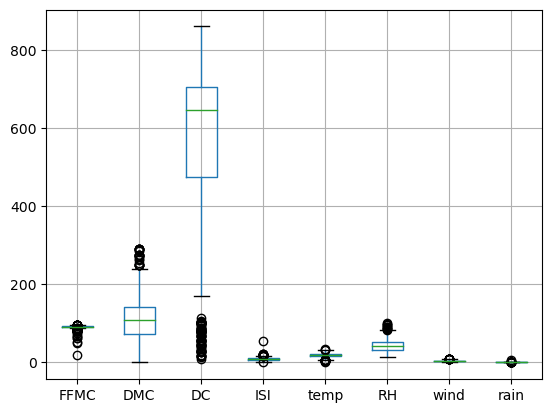

In [33]:
# Checking for outliers in the dataset
imputed_clean.boxplot(column = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain'])
plt.show() 

In [34]:
# Calculating for the presence of outliers

for col in imputed_clean:

    quartiles = np.percentile(fires[col], [25, 50, 75])
    iqr = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - (1.5 * iqr)
    upper_bound = quartiles[2] + (1.5 * iqr)
    num_outliers =sum((imputed_clean[col] < lower_bound) | (imputed_clean[col] > upper_bound))

    print(f"The {col} column has {num_outliers} outliers according to the boxplot method.")

The FFMC column has 0 according to the boxplot method.
The DMC column has 0 according to the boxplot method.
The DC column has 0 according to the boxplot method.
The ISI column has 0 according to the boxplot method.
The temp column has 0 according to the boxplot method.
The RH column has 0 according to the boxplot method.
The wind column has 0 according to the boxplot method.
The rain column has 0 according to the boxplot method.


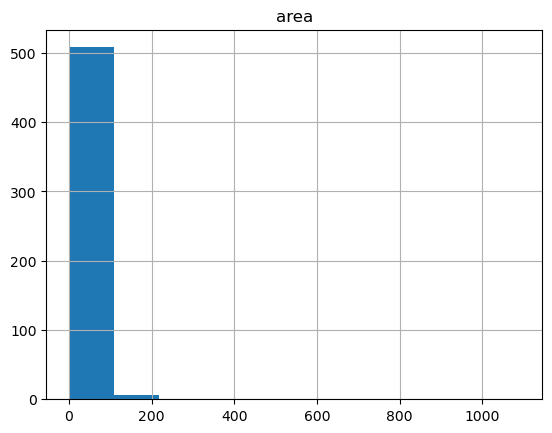

In [35]:
fires.hist('area')
plt.show()

The outcome is highly right-skewed with extremely damaging fires. Furthermore, many of the rows have outcome values that are zero or near-zero. It might be worth it to log-transform the data. Note though that some of the outcomes are actually 0, so we can add 1 to prevent any errors. Recall that log(0) is undefined.

In [36]:
fires["log_area"] = np.log(fires["area"] + 1)

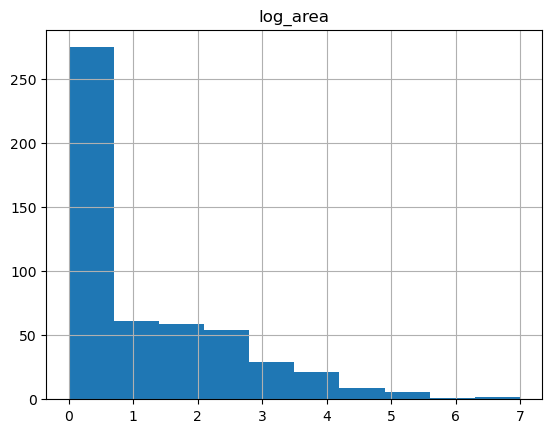

In [37]:
fires.hist('log_area')
plt.show()

We can see that performing a log-transformation doesn't produce a bell-shaped distribution, but it does spread out the data a bit more than without the transformation. It's probably the case that most fires do not appreciably damage the forest, so we would be mistaken in removing all of these rows.

Instead of using month directly, we'll derive another feature called summer that takes a value of 1 when the fire occurred during the summer. The idea here is that summer months are typically hotter, so fires are more likely.

In [38]:
def summer_month(month):
    if month in ["jun", "jul", "aug"]:
        return 1
    else:
        return 0
    
fires['summer'] = fires['month'].apply(summer_month)

In [40]:
new_fire = pd.concat([imputed_clean, fires['summer']], axis=1)

# Standardizing the dataset

scaler = StandardScaler()
scaled_fire = scaler.fit_transform(new_fire)

In [41]:
new_fire.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,summer
0,86.2,26.200000,94.300000,5.1,18.884677,51.0,6.700000,0.0,0
1,90.6,111.195363,669.100000,6.7,18.000000,33.0,0.900000,0.0,0
2,90.6,43.700000,550.673418,6.7,14.600000,33.0,1.300000,0.0,0
3,91.7,33.300000,77.500000,9.0,8.300000,97.0,4.000000,0.2,0
4,89.3,51.300000,102.200000,9.6,11.400000,99.0,4.021784,0.0,0


In [44]:
scaled_fire

# Converting the standardizes dataset in array to dataframe

fire = pd.DataFrame(scaled_fire, columns=['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'summer'])

In [45]:
fire.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,summer
0,-0.807982,-1.357065,-1.939062,-0.860975,-6.316291e-16,0.421862,1.547336,-0.078116,-0.905772
1,0.003618,0.000000,0.503177,-0.509452,-1.572848e-01,-0.725529,-1.803607,-0.078116,-0.905772
2,0.003618,-1.077654,0.000000,-0.509452,-7.617633e-01,-0.725529,-1.572507,-0.078116,-0.905772
3,0.206518,-1.243704,-2.010443,-0.004138,-1.881826e+00,3.354081,-0.012586,0.598427,-0.905772
4,-0.236173,-0.956310,-1.905496,0.127683,-1.330684e+00,3.481569,0.000000,-0.078116,-0.905772


## Subset Selection

In [51]:
y = fires['log_area']

lr2 = LinearRegression()
lr4 = LinearRegression()
lr6 = LinearRegression()

forward2 = SequentialFeatureSelector(estimator=lr2,
                                     n_features_to_select=2, 
                                     direction="forward")

forward4 = SequentialFeatureSelector(estimator=lr4,
                                     n_features_to_select=4, 
                                     direction="forward")

forward6 = SequentialFeatureSelector(estimator=lr6,
                                       n_features_to_select=6, 
                                       direction="forward")

backward2 = SequentialFeatureSelector(estimator=lr2,
                                     n_features_to_select=2, 
                                     direction="backward")

backward4 = SequentialFeatureSelector(estimator=lr4,
                                     n_features_to_select=4, 
                                     direction="backward")

backward6 = SequentialFeatureSelector(estimator=lr6,
                                       n_features_to_select=6, 
                                       direction="backward")

forward2.fit(fire, y)
forward4.fit(fire, y)
forward6.fit(fire, y)

backward2.fit(fire, y)
backward4.fit(fire, y)
backward6.fit(fire, y)

print("Features selected in 2 forward feature model:", forward2.get_feature_names_out())
print("Features selected in 4 forward feature model:", forward4.get_feature_names_out())
print("Features selected in 6 forward feature model:", forward6.get_feature_names_out())
print("Features selected in 2 backward feature model:", backward2.get_feature_names_out())
print("Features selected in 4 backward feature model:", backward4.get_feature_names_out())
print("Features selected in 6 backward feature model:", backward6.get_feature_names_out())

Features selected in 2 forward feature model: ['FFMC' 'DC']
Features selected in 4 forward feature model: ['FFMC' 'DC' 'RH' 'wind']
Features selected in 6 forward feature model: ['FFMC' 'DC' 'ISI' 'RH' 'wind' 'summer']
Features selected in 2 backward feature model: ['DC' 'wind']
Features selected in 4 backward feature model: ['FFMC' 'DC' 'RH' 'wind']
Features selected in 6 backward feature model: ['FFMC' 'DC' 'ISI' 'RH' 'wind' 'summer']


Based on the features chosen by forward and backward selection, it seems like DC, wind, RH and FFMC seem to be the most impactful on predicting log_area

## More Candidate Models

Another approach we might consider taking is using regularized versions of linear regression. Fires have many factors that can increase the damaage they have, so it seems unhelpful to restrict our model to a univariate, non-linear model.

In [52]:

ridge = RidgeCV(alphas = np.linspace(1, 10000, num=1000))
lasso = LassoCV(alphas = np.linspace(1, 10000, num=1000))

ridge.fit(fire, y)
lasso.fit(fire, y)

print("Ridge tuning parameter: ", ridge.alpha_)
print("LASSO tuning parameter: ", lasso.alpha_)

print("Ridge coefficients: ", ridge.coef_)
print("LASSO coefficients: ", lasso.coef_)

Ridge tuning parameter:  871.7837837837839
LASSO tuning parameter:  10000.0
Ridge coefficients:  [ 0.01833072  0.0344503   0.02500638 -0.01442807  0.0146375  -0.02341992
  0.03626537  0.01146793 -0.03385057]
LASSO coefficients:  [ 0.  0.  0. -0.  0. -0.  0.  0. -0.]


The LASSO tuning parameter always seems to be on the extreme. Given that the outcome has many small values, it suggests that having no features at all is better than having any. We'll try to home in on a better tuning parameter value below by choosing a smaller range to pick from.

In [55]:
ridge = RidgeCV(alphas = np.linspace(100, 1000, num=1000))
ridge.fit(fire, y)
print("Ridge tuning parameter: ", ridge.alpha_)

Ridge tuning parameter:  869.3693693693693


We'll use this value in k-fold cross-validation, rounded to the hundredths place. We'll use a ridge regression and choose not to use a LASSO model here since the regularization results aren't helpful.

## K-Fold Cross-Validation

In [57]:
ref = LinearRegression() 
fw2_model = LinearRegression() 
fw4_model = LinearRegression() 
fw6_model = LinearRegression() 

bw2_model = LinearRegression() 
bw4_model = LinearRegression() 
bw6_model = LinearRegression() 

ref_cv = cross_val_score(ref, fire[["wind", "temp"]], y, cv = 5, scoring = "neg_mean_squared_error")
fw2_cv = cross_val_score(fw2_model, fire[forward2.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
fw4_cv = cross_val_score(fw4_model, fire[forward4.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
fw6_cv = cross_val_score(fw6_model, fire[forward6.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw2_cv = cross_val_score(bw2_model, fire[backward2.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw4_cv = cross_val_score(bw4_model, fire[backward4.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw6_cv = cross_val_score(bw6_model, fire[backward6.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
ridge_cv = cross_val_score(ridge, fire, y, cv = 5, scoring = "neg_mean_squared_error")

In [58]:
print("Reference Model, Avg Test MSE: ", np.mean(ref_cv), " SD: ", np.std(ref_cv))
print("Forward-2 Model, Avg Test MSE: ", np.mean(fw2_cv), " SD: ", np.std(fw2_cv))
print("Forward-4 Model, Avg Test MSE: ", np.mean(fw4_cv), " SD: ", np.std(fw4_cv))
print("Forward-6 Model, Avg Test MSE: ", np.mean(fw6_cv), " SD: ", np.std(fw6_cv))
print("Backward-2 Model, Avg Test MSE: ", np.mean(bw2_cv), " SD: ", np.std(bw2_cv))
print("Backward-4 Model, Avg Test MSE: ", np.mean(bw4_cv), " SD: ", np.std(bw4_cv))
print("Backward-6 Model, Avg Test MSE: ", np.mean(bw6_cv), " SD: ", np.std(bw6_cv))
print("Ridge Model, Avg Test MSE: ", np.mean(bw6_cv), " SD: ", np.std(bw6_cv))

Reference Model, Avg Test MSE:  -2.206347659540237  SD:  1.0623994281625386
Forward-2 Model, Avg Test MSE:  -2.1770776049957496  SD:  1.0250616783685385
Forward-4 Model, Avg Test MSE:  -2.1950201058797294  SD:  1.004708758464694
Forward-6 Model, Avg Test MSE:  -2.2420632487795586  SD:  1.0174420937084652
Backward-2 Model, Avg Test MSE:  -2.1763387912782712  SD:  1.0121713974134083
Backward-4 Model, Avg Test MSE:  -2.1950201058797294  SD:  1.004708758464694
Backward-6 Model, Avg Test MSE:  -2.2420632487795586  SD:  1.0174420937084652
Ridge Model, Avg Test MSE:  -2.2420632487795586  SD:  1.0174420937084652


Among our candidate models, the backward selection model using two features performs the best, with an average MSE of -2.17. However, note that this is on the log-scale, so this suggests that the predictions are off by a magnitude of about 2. On the surface, this suggests that the models overall are not good predictors.

However, this problem is known to be a difficult one. The extreme skew in the outcome hurts many of the assumptions needed by linear models. We hope that this showcases that machine learning is not a universal fix. Several problems have characteristics that make prediction difficult.